In [6]:
!python3 -m pip install ipympl pyserial scikit-learn numpy matplotlib ipywidgets

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
# For widgets support
!pip install jupyterlab-widgets

# For interactive matplotlib
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Button(description='Stop', style=ButtonStyle())

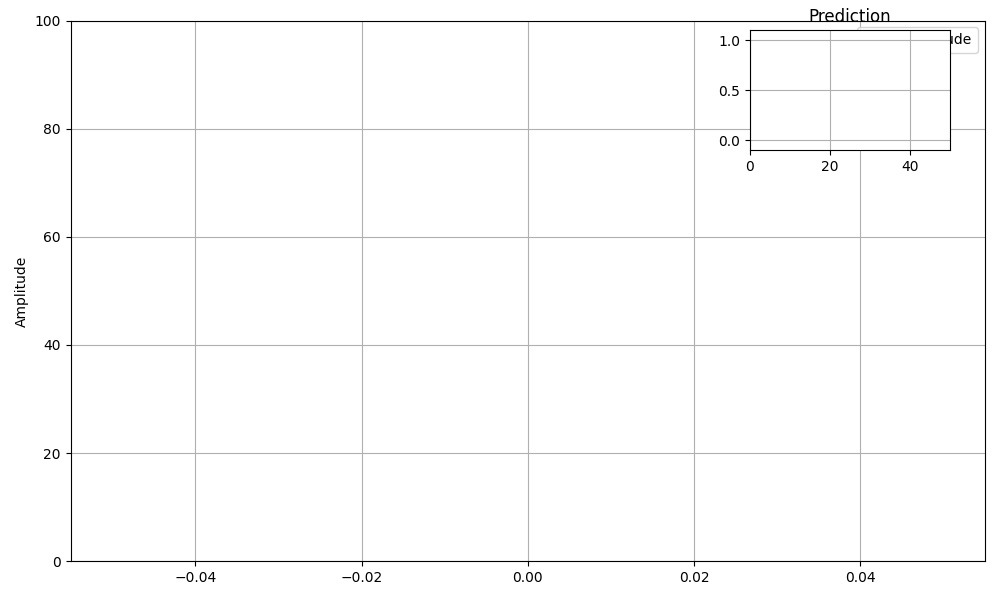

In [11]:
%matplotlib widget
import ipywidgets as widgets
import serial
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from threading import Thread
from collections import deque

# Settings
PORT = 'COM4'
BAUD = 115200
MODEL_PATH = 'svc_model.pkl'
SCALER_PATH = 'scaler.pkl'
MAX_POINTS = 50

# Buffers (only envelope and predictions are used)
env_buffer = deque(maxlen=MAX_POINTS)
pred_buffer = deque(maxlen=MAX_POINTS)
timestamps = deque(maxlen=MAX_POINTS)
pred_lock = False

# Set up figure with one main axis for the envelope data
plt.ioff()
fig, ax = plt.subplots(figsize=(10, 6))
env_line, = ax.plot([], [], 'g-', lw=1, label='Amplitude')
ax.set_ylabel('Amplitude')
ax.set_ylim(0, 100)  # Adjust as needed
ax.legend(loc='upper right')
ax.grid(True)
fig.canvas.header_visible = False  # Reduce Jupyter UI latency
fig.tight_layout()

# -- Create an inset axis for showing binary predictions --
# [left, bottom, width, height] in relative figure coordinates.
inset_ax = fig.add_axes([0.75, 0.75, 0.2, 0.2])
inset_ax.set_ylim(-0.1, 1.1)
inset_ax.set_xlim(0, MAX_POINTS)
inset_ax.set_title("Prediction")
inset_ax.grid(True)
pred_line_inset, = inset_ax.plot([], [], 'ro-', ms=6, alpha=0.8)

class SerialReader(Thread):
    def __init__(self):
        super().__init__(daemon=True)
        self.ser = serial.Serial(PORT, BAUD, timeout=0.05)
        self.model = joblib.load(MODEL_PATH)
        self.scaler = joblib.load(SCALER_PATH)
        self.running = True

    def run(self):
        global pred_lock
        while self.running:
            try:
                # Bulk read for efficiency
                data = self.ser.read(1024).decode(errors='ignore')
                for line in data.split('\n'):
                    if line.count(',') == 2:
                        ts, raw, env = line.strip().split(',')
                        ts = float(ts) / 1000  # convert ms to seconds
                        
                        # Update buffers (ignoring raw data)
                        timestamps.append(ts)
                        env_buffer.append(int(env))
                        
                        # Make predictions at about 20Hz (every 5 points)
                        if not pred_lock:
                            pred_lock = True
                            # Use the same column name as used in training ("Envelope")
                            X = pd.DataFrame([[env_buffer[-1]]], columns=['Envelope'])
                            X_scaled = self.scaler.transform(X)
                            # Use only the scaled data for prediction
                            pred = self.model.predict(X_scaled)[0]
                            pred_buffer.append((ts, pred))
                            pred_lock = False
            except Exception as e:
                # Optionally log the exception: print(e)
                pass

    def stop(self):
        self.running = False
        self.ser.close()

def update(frame):
    # Update envelope (amplitude) plot on main axis
    env_line.set_data(timestamps, env_buffer)
    if timestamps:
        ax.set_xlim(timestamps[0], timestamps[-1])
    
    # Update the inset with prediction data
    if pred_buffer:
        pred_ts, pred_vals = zip(*pred_buffer)
        pred_line_inset.set_data(pred_ts, pred_vals)
        inset_ax.set_xlim(pred_ts[0], pred_ts[-1])
    
    return env_line, pred_line_inset

# Start the serial reading thread and animation
reader = SerialReader()
reader.start()

ani = FuncAnimation(fig, update, blit=True, interval=10, cache_frame_data=False)

# Create and display a stop button
stop_btn = widgets.Button(description="Stop")
display(stop_btn)

def on_stop(b):
    reader.stop()
    ani.event_source.stop()
    plt.close()
    clear_output()
    print("Stopped")

stop_btn.on_click(on_stop)

display(fig.canvas)


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Button(description='Stop', style=ButtonStyle())

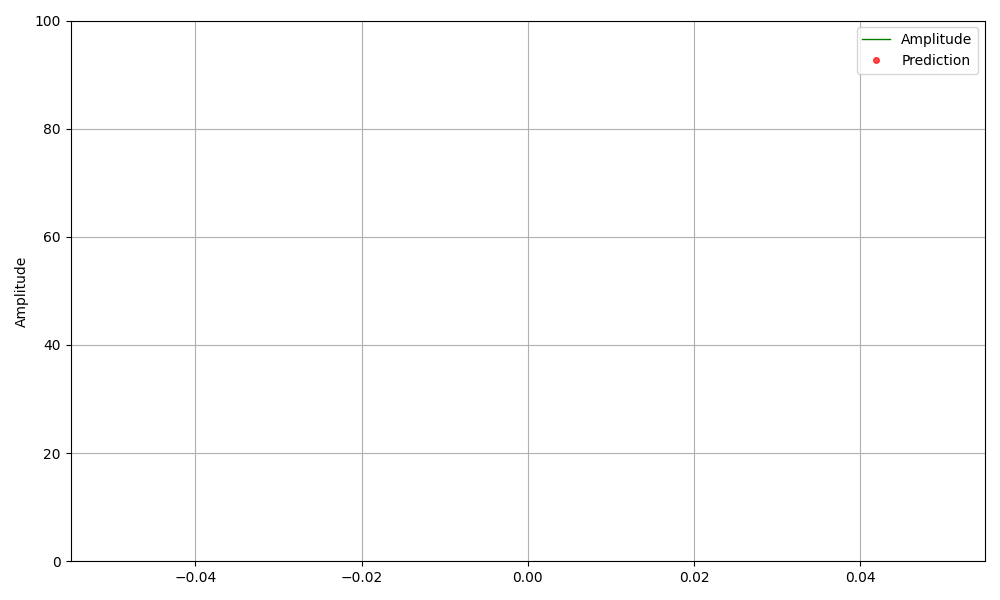

In [10]:
%matplotlib widget  
import ipywidgets as widgets
import serial
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from threading import Thread
from collections import deque

# Settings
PORT = 'COM4'
BAUD = 115200
MODEL_PATH = 'svc_model.pkl'
SCALER_PATH = 'scaler.pkl'
MAX_POINTS = 200

# Buffers (only envelope and predictions are used)
env_buffer = deque(maxlen=MAX_POINTS)
pred_buffer = deque(maxlen=MAX_POINTS)
timestamps = deque(maxlen=MAX_POINTS)
pred_lock = False

# Set up figure with only one subplot for amplitude & prediction
plt.ioff()
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for amplitude (envelope) and predictions
env_line, = ax.plot([], [], 'g-', lw=1, label='Amplitude')
pred_line, = ax.plot([], [], 'ro', ms=4, alpha=0.7, label='Prediction')
ax.set_ylabel('Amplitude')
ax.set_ylim(0, 100)  # Adjust this value to "zoom out" the amplitude as needed
ax.legend(loc='upper right')
ax.grid(True)

fig.canvas.header_visible = False  # Reduce Jupyter UI latency
fig.tight_layout()

class SerialReader(Thread):
    def __init__(self):
        super().__init__(daemon=True)
        self.ser = serial.Serial(PORT, BAUD, timeout=0.1)
        self.model = joblib.load(MODEL_PATH)
        self.scaler = joblib.load(SCALER_PATH)
        self.running = True

    def run(self):
        global pred_lock
        while self.running:
            try:
                # Bulk read for efficiency
                data = self.ser.read(1024).decode(errors='ignore')
                for line in data.split('\n'):
                    if line.count(',') == 2:
                        ts, raw, env = line.strip().split(',')
                        ts = float(ts) / 1000  # convert ms to seconds
                        
                        # Update buffers (ignore raw data)
                        timestamps.append(ts)
                        env_buffer.append(int(env))
                        
                        # Make predictions at about 20Hz (every 5 points)
                        if not pred_lock and len(env_buffer) % 5 == 0:
                            pred_lock = True
                            # Wrap the data in a DataFrame with the proper feature name ('env')
                            X = pd.DataFrame([[env_buffer[-1]]], columns=['env'])
                            X_scaled = self.scaler.transform(X)  # Returns a numpy array without feature names
                            pred = self.model.predict(X_scaled)[0]                            
                            pred = self.model.predict(X)[0]
                            pred_buffer.append((ts, pred))
                            pred_lock = False
            except Exception as e:
                # Optionally log the exception: print(e)
                pass

    def stop(self):
        self.running = False
        self.ser.close()

def update(frame):
    # Update amplitude (envelope) and predictions plot
    env_line.set_data(timestamps, env_buffer)
    if pred_buffer:
        pred_ts, pred_vals = zip(*pred_buffer)
        # Multiply prediction values if needed for visibility
        pred_line.set_data(pred_ts, [v * 1000 for v in pred_vals])
    if timestamps:
        ax.set_xlim(timestamps[0], timestamps[-1])
    return env_line, pred_line

# Start the serial reading thread and animation
reader = SerialReader()
reader.start()

ani = FuncAnimation(fig, update, blit=True, interval=20, cache_frame_data=False)

# Create and display a stop button
stop_btn = widgets.Button(description="Stop")
display(stop_btn)

def on_stop(b):
    reader.stop()
    ani.event_source.stop()
    plt.close()
    clear_output()
    print("Stopped")

stop_btn.on_click(on_stop)

display(fig.canvas)